In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [89]:
btcn = pd.read_csv('/Users/connorturnage/Desktop/bitcoin.csv')

In [90]:
eth = pd.read_csv('/Users/connorturnage/Desktop/ethereum.csv')

In [4]:
rip = pd.read_csv('/Users/connorturnage/Desktop/ripple_price.csv')

In [92]:
rip

,Date,Open,High,Low,Close,Volume,Market Cap
0,4-Aug-13,0.005874,0.005927,0.005874,0.005882,-,"45,921,000"
1,5-Aug-13,0.005875,0.005980,0.005613,0.005613,-,"45,928,400"
2,6-Aug-13,0.005637,0.005661,0.004629,0.004680,-,"44,067,600"
3,7-Aug-13,0.004669,0.004682,0.004333,0.004417,-,"36,503,500"
4,8-Aug-13,0.004397,0.004424,0.004175,0.004254,-,"34,372,500"
...,...,...,...,...,...,...,...
1657,16-Feb-18,1.140000,1.150000,1.110000,1.140000,"568,339,000","44,663,300,000"
1658,17-Feb-18,1.140000,1.220000,1.130000,1.200000,"1,186,730,000","44,370,200,000"
1659,18-Feb-18,1.200000,1.210000,1.090000,1.120000,"1,113,650,000","46,997,500,000"
1660,19-Feb-18,1.120000,1.170000,1.120000,1.140000,"556,304,000","43,813,300,000"


In [93]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y, regresults = True)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

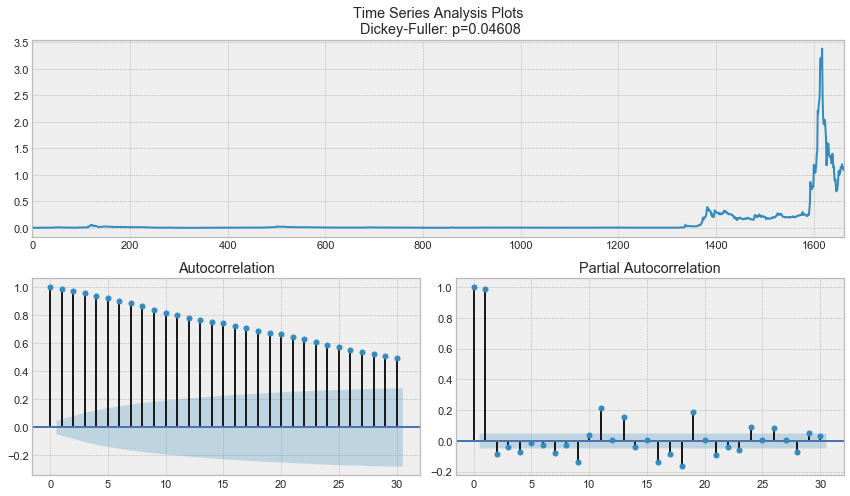

In [94]:
tsplot(rip.Close, lags=30)
#Unit Root!

In [95]:
rip_diff = rip.Close - rip.Close.shift(1)

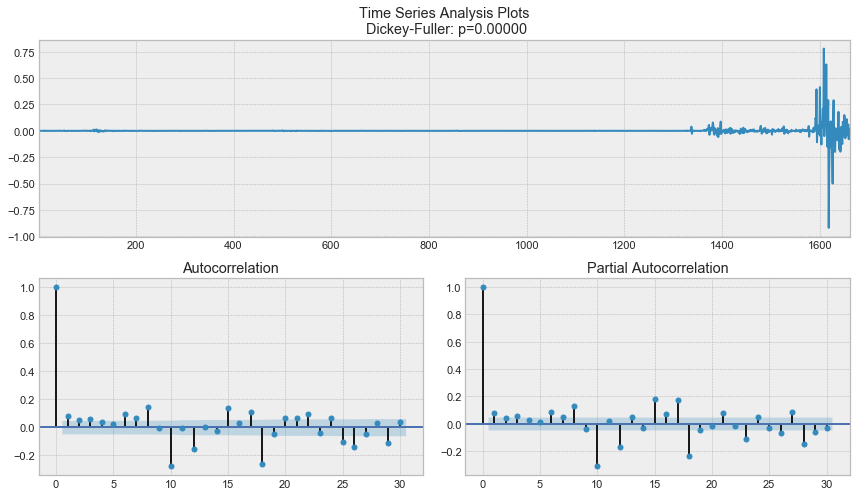

In [96]:
tsplot(rip_diff[1:], lags=30)

In [97]:
from statsmodels.tsa.arima_model import ARIMA

In [98]:
model = ARIMA(rip.Close, order=(8,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1661
Model:                 ARIMA(8, 1, 2)   Log Likelihood                2868.318
Method:                       css-mle   S.D. of innovations              0.043
Date:                Sun, 01 Mar 2020   AIC                          -5712.636
Time:                        13:08:22   BIC                          -5647.654
Sample:                             1   HQIC                         -5688.551
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0006      0.002      0.392      0.695      -0.003       0.004
ar.L1.D.Close     0.3588      0.036     10.045      0.000       0.289       0.429
ar.L2.D.Close    -0.8610      0.031    -

In [59]:
from tqdm import tqdm_notebook
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(rip.Close, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(rip.Close, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())


                                 Statespace Model Results                                
Dep. Variable:                             Close   No. Observations:                 1662
Model:             SARIMAX(3, 1, 4)x(4, 1, 3, 5)   Log Likelihood                2921.564
Date:                           Sat, 29 Feb 2020   AIC                          -5813.128
Time:                                   12:04:00   BIC                          -5731.946
Sample:                                        0   HQIC                         -5783.034
                                          - 1662                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1691      0.027      6.269      0.000       0.116       0.222
ar.L2          0.0346      0.023      1.48

In [107]:
def optimize_SARIMA(parameters_list, d, D, s):
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(rip_diff, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(rip_diff, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())


                                 Statespace Model Results                                
Dep. Variable:                             Close   No. Observations:                 1662
Model:             SARIMAX(4, 1, 4)x(2, 1, 3, 5)   Log Likelihood                2912.137
Date:                           Sun, 01 Mar 2020   AIC                          -5796.273
Time:                                   16:02:26   BIC                          -5720.503
Sample:                                        0   HQIC                         -5768.186
                                          - 1662                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5153      0.019    -26.906      0.000      -0.553      -0.478
ar.L2         -0.5268      0.011    -47.91

In [99]:
best_rip_model = sm.tsa.statespace.SARIMAX(rip.Close, order=(3, 1, 4),
                                       seasonal_order=(4, 1, 3, 5)).fit(disp=-1)

print(best_rip_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             Close   No. Observations:                 1662
Model:             SARIMAX(3, 1, 4)x(4, 1, 3, 5)   Log Likelihood                2921.564
Date:                           Sun, 01 Mar 2020   AIC                          -5813.128
Time:                                   13:09:59   BIC                          -5731.946
Sample:                                        0   HQIC                         -5783.034
                                          - 1662                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1691      0.027      6.269      0.000       0.116       0.222
ar.L2          0.0346      0.023      1.480

In [111]:
diff_rip_model = sm.tsa.statespace.SARIMAX(rip_diff, order=(4, 1, 4),
                                       seasonal_order=(2, 1, 3, 5)).fit(disp=-1)

print(diff_rip_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             Close   No. Observations:                 1662
Model:             SARIMAX(4, 1, 4)x(2, 1, 3, 5)   Log Likelihood                2912.137
Date:                           Sun, 01 Mar 2020   AIC                          -5796.273
Time:                                   16:04:18   BIC                          -5720.503
Sample:                                        0   HQIC                         -5768.186
                                          - 1662                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5153      0.019    -26.906      0.000      -0.553      -0.478
ar.L2         -0.5268      0.011    -47.916

In [100]:
residuals = DataFrame(best_rip_model.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

NameError: name 'DataFrame' is not defined

In [5]:
# Input data for forecasting
rip_forecast_input = rip.Close[-1661:]
rip_forecast_input

1       0.005613
2       0.004680
3       0.004417
4       0.004254
5       0.004291
          ...   
1657    1.140000
1658    1.200000
1659    1.120000
1660    1.140000
1661    1.090000
Name: Close, Length: 1661, dtype: float64

In [104]:
rip_fc = best_rip_model.forecast(y=rip_forecast_input, steps=28)
rip_forecast = pd.DataFrame(rip_fc)
rip_forecast.reset_index(inplace=True,drop=True)
rip_forecast


,0
0,1.140227
1,1.082165
2,1.054158
3,1.028843
4,1.009330
5,1.046090
6,1.140442
7,1.166241
8,1.148834
9,1.150755


No handles with labels found to put in legend.


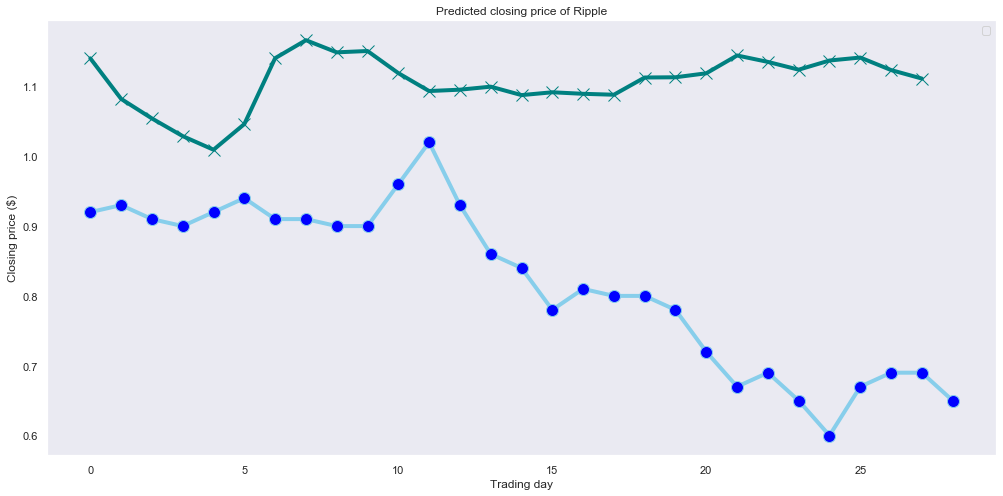

In [105]:
rip_actual = pd.read_csv('/Users/connorturnage/Desktop/rip_actual.csv')

plt.figure(figsize=(17, 8))
plt.plot(rip_actual.Price, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot(rip_forecast, marker='x', markerfacecolor='green', markersize=12, color='teal', linewidth=4)
plt.title('Predicted closing price of Ripple')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.legend(loc='best')
plt.grid(False)
plt.show()

In [112]:
# Input data for forecasting
diff_forecast_input = rip_diff[-1661:]
diff_forecast_input

1      -0.000269
2      -0.000933
3      -0.000263
4      -0.000163
5       0.000037
          ...   
1657   -0.010000
1658    0.060000
1659   -0.080000
1660    0.020000
1661   -0.050000
Name: Close, Length: 1661, dtype: float64

In [ ]:
rip_fc_diff = dif_rip_model.forecast(y=rip_forecast_input, steps=28)
rip_forecast = pd.DataFrame(rip_fc)
rip_forecast.reset_index(inplace=True,drop=True)
rip_forecast